Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

In [1]:
import retinoto_py as fovea
args = fovea.Params(do_mask=True, num_epochs=5)
args

Params(image_size=224, do_mask=True, do_fovea=False, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=5, subset_factor=1, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=False)

# transfer learning of each network on the  masked dataset

In [2]:
%ls -ltr cached_data/20*

-rw-r--r--  1 laurentperrinet  staff  354499245  5 déc.  06:38 cached_data/20_model_name=convnext_base_dataset=bbox.pth
-rw-r--r--  1 laurentperrinet  staff        759  5 déc.  06:38 cached_data/20_model_name=convnext_base_dataset=bbox.json
-rw-r--r--@ 1 laurentperrinet  staff          0  5 déc.  18:19 cached_data/20_model_name=convnext_base_dataset=bbox.lock


In [3]:
# %rm "cached_data/20_mls -ltrodel_name=convnext_base_dataset=bbox.lock"   # FORCING RECOMPUTE
# %rm "cached_data/20_*.lock"   # FORCING RECOMPUTE
# %rm "cached_data/20_model_name=resnet101_dataset=full.lock"   # FORCING RECOMPUTE


In [4]:
model_name = args.model_name
for dataset in ['bbox']: # fovea.all_datasets:
    name = f'20_model_name={model_name}_dataset={dataset}'
    model_filename, json_filename = fovea.do_learning(args, dataset, name)
    print(50*'.')

Load JSON from pre-trained resnet cached_data/20_model_name=convnext_base_dataset=bbox.json
cached_data/20_model_name=convnext_base_dataset=bbox.pth: accuracy = 0.811
..................................................


## Model comparison

In [5]:
model_name = args.model_name
for dataset in ['bbox']: # fovea.all_datasets:
    results = fovea.pd.read_json(args.data_cache / f'20_model_name={model_name}_dataset={dataset}.json')
    print(model_name, dataset, results.tail(1)['acc_val'])

convnext_base bbox 3    0.813644
Name: acc_val, dtype: float64


In [6]:
results.T

,0,1,2,3
epoch,0.000000,1.000000e+00,2.000000e+00,3.000000e+00
i_image,615280.000000,6.152800e+05,6.152800e+05,6.152800e+05
total_image,615280.000000,1.230560e+06,1.845840e+06,2.461120e+06
loss_train,2.122802,2.093896e+00,2.084253e+00,2.077628e+00
acc_train,0.926996,9.332857e-01,9.356634e-01,9.371977e-01
acc_val,0.806965,8.102736e-01,8.120398e-01,8.136443e-01
time,7059.062819,1.410944e+04,2.116042e+04,2.820790e+04


In [7]:
results_13 = fovea.pd.read_json(args.data_cache / '13_model_comparison.json')
results_13

,model_name,do_mask,dataset,accuracy,wall_clock_time,total_parameters,trainable_parameters,total_layers
0,resnet18,True,full,0.515400,0.003884,11689512,11689512,68
1,resnet50,True,full,0.788860,0.005536,25557032,25557032,151
2,resnet101,True,full,0.801120,0.007081,44549160,44549160,287
3,resnet18,True,bbox,0.430846,0.004722,11689512,11689512,68
4,resnet50,True,bbox,0.721915,0.006415,25557032,25557032,151
5,resnet101,True,bbox,0.751393,0.007409,44549160,44549160,287
6,resnet18,False,full,0.691620,0.004008,11689512,11689512,68
7,resnet50,False,full,0.807600,0.005385,25557032,25557032,151
8,resnet101,False,full,0.817300,0.007105,44549160,44549160,287
9,resnet18,False,bbox,0.627786,0.004341,11689512,11689512,68


## Plot learning evolution

Load JSON from pre-trained resnet cached_data/20_model_name=convnext_base_dataset=bbox.json
cached_data/20_model_name=convnext_base_dataset=bbox.pth: accuracy = 0.811
Training model convnext_base, file= cached_data/20_model_name=convnext_base_dataset=bbox.pth - image_size=224


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch=5/5:   0%|          | 0/7691 [00:02<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:03<?, ?it/s]

Training of ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          

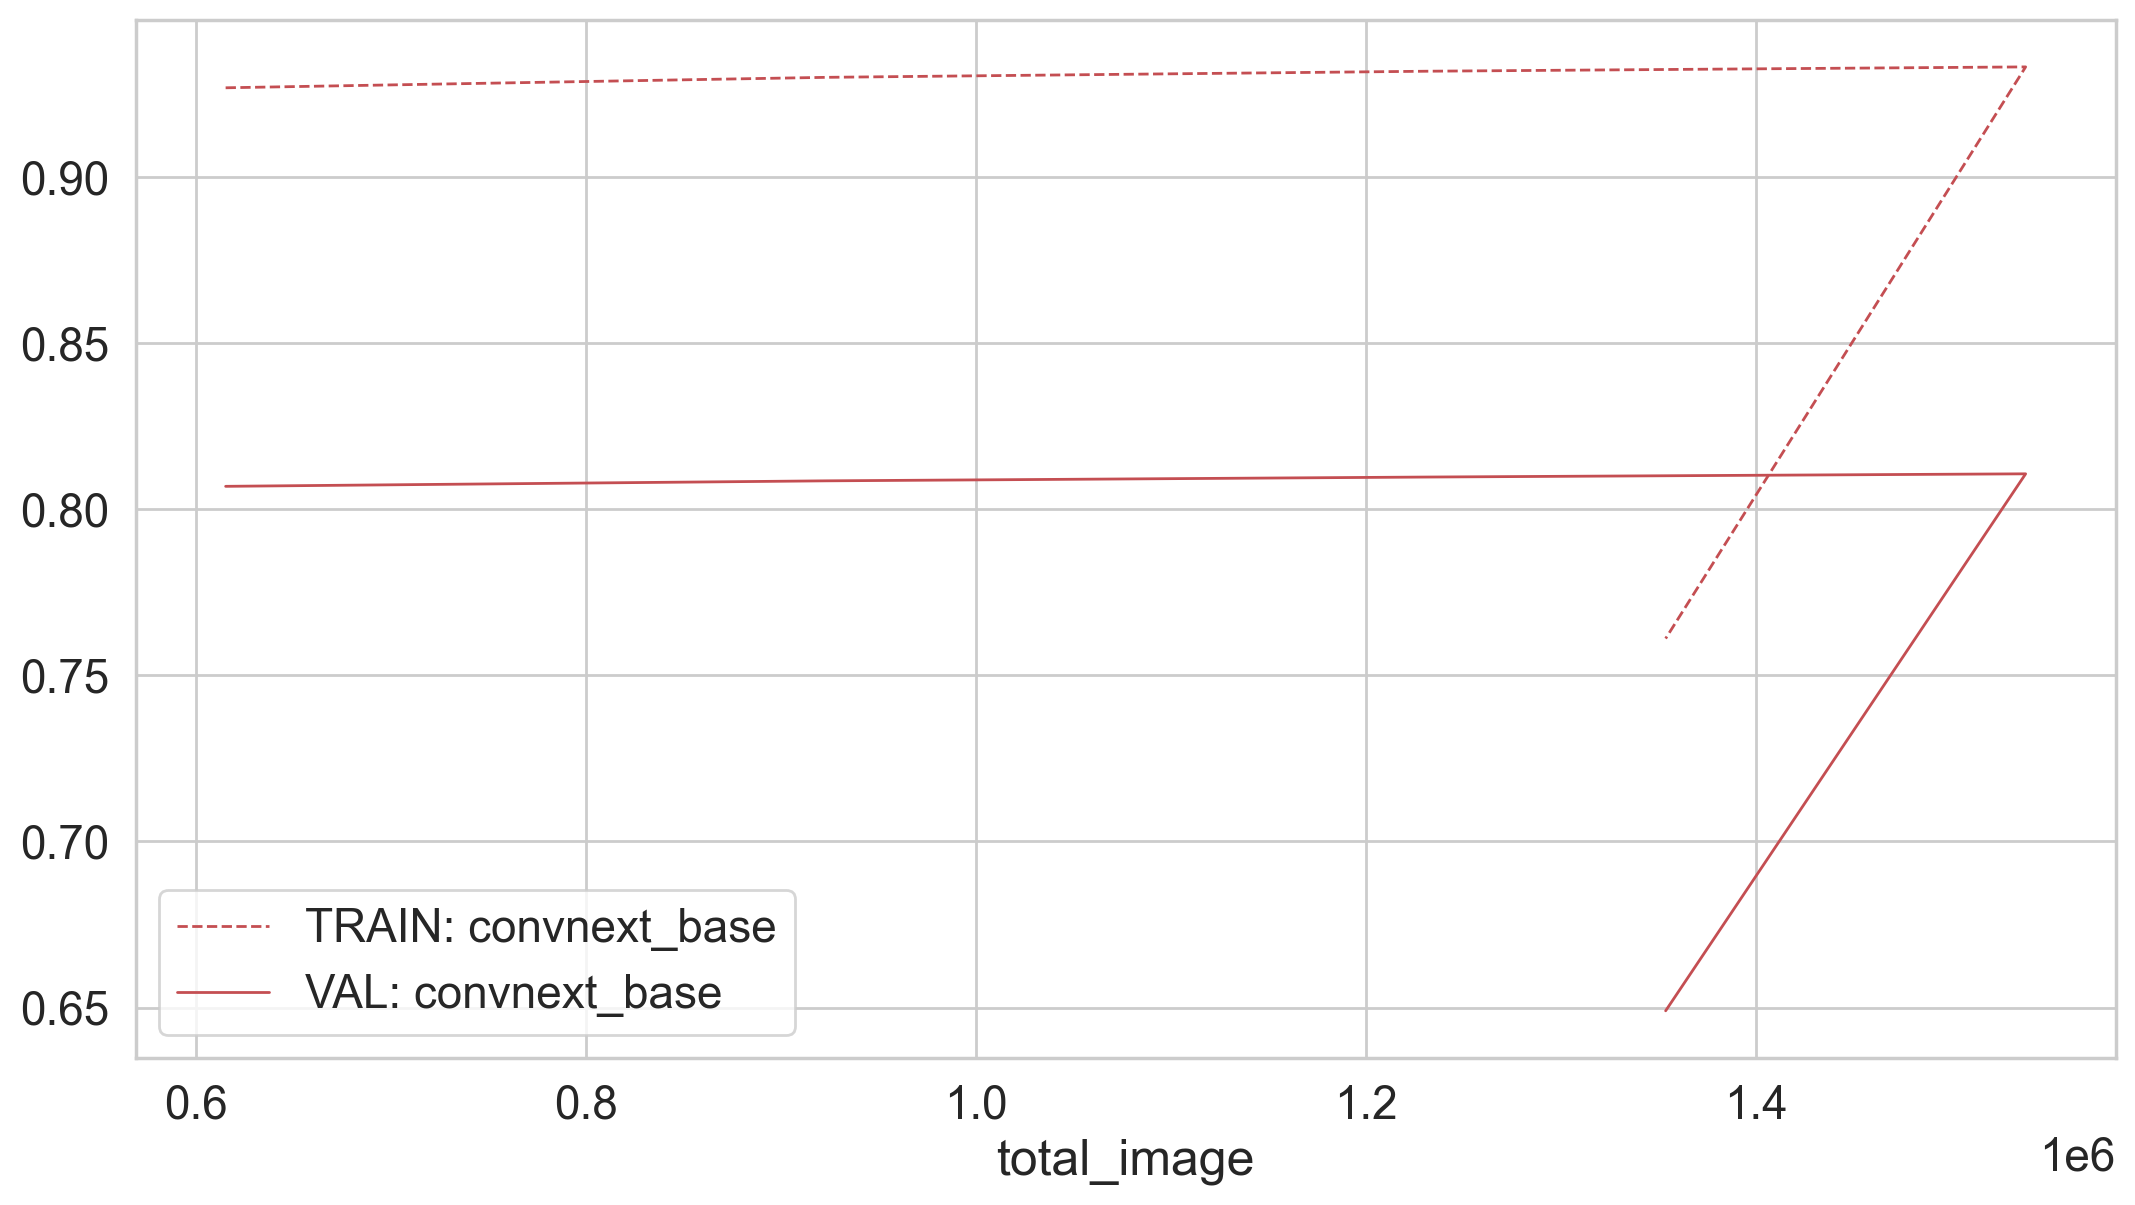

In [8]:
fig, ax = fovea.plt.subplots()
for dataset in ['bbox']: # fovea.all_datasets:
    color = 'r'
    lw = 1

    name = f'20_model_name={model_name}_dataset={dataset}'
    model_filename, json_filename = fovea.do_learning(args, dataset, name)

    df_train = fovea.pd.read_json(json_filename, orient='records')

    df_train_roll = df_train.rolling(window=5, min_periods=1, center=False).mean()
    ax = df_train_roll.plot(x='total_image', y='acc_train', 
                        c=color, ls='dashed', lw=lw,
                        grid=True, ax=ax, label='TRAIN: ' + args.model_name)    
    ax = df_train_roll.plot(x='total_image', y='acc_val', 
                        c=color, lw=lw,
                        grid=True, ax=ax, label='VAL: ' + args.model_name)   

In [9]:
df_train

,epoch,i_image,total_image,loss_train,acc_train,acc_val,time
0,0,615280,615280,2.122802,0.926996,0.806965,7059.062819
1,1,615280,1230560,2.093896,0.933286,0.810274,14109.442835
2,2,615280,1845840,2.084253,0.935663,0.812040,21160.418741
3,3,615280,2461120,2.077628,0.937198,0.813644,28207.904079
4,4,615280,615280,0.132174,0.072455,0.002114,30728.584105
